# Completion Trie and metrics

Evaluation of a completion system on wikpedia pages.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [ ]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3049881,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ["Festival d'Angouleme 1982",
  "Festival d'Angouleme 1983",
  "Festival d'Angouleme 1984",
  "Festival d'Angouleme 1985",
  "Festival d'Angouleme 1986"])

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [ ]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.2999896084613638s - nb=200 gain (0.8165775401069528, 0.8165775401069528, 0.8165775401069528, 1.0)
time: 0.7144828541750678s - nb=500 gain (0.8146229130685121, 0.8146229130685121, 0.8146229130685121, 1.0)
time: 1.0986195503756564s - nb=800 gain (0.790486835568804, 0.790486835568804, 0.790486835568804, 1.0)
time: 1.3131210066877887s - nb=1000 gain (0.7735973263115256, 0.7735973263115256, 0.7735973263115256, 1.0)
time: 2.7534412884481587s - nb=2000 gain (0.7478345299844136, 0.7478345299844136, 0.7478345299844136, 1.0)
time: 6.149774144397913s - nb=5000 gain (0.714945282188298, 0.7150067053632619, 0.7150067053632619, 1.0)
time: 9.947369208801932s - nb=8000 gain (0.6993198666505233, 0.6993198666505233, 0.6993198666505233, 1.0)
time: 12.778455817358662s - nb=10000 gain (0.6859539619979459, 0.6859539619979459, 0.6859539619979459, 1.0)
time: 23.01611500995749s - nb=20000 gain (0.6578850499493512, 0.65799496927368, 0.65799496927368, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,12.778456,0.685954,0.685954,0.685954,1.0,0.685954,1.0,0.685954,1.000000,0.685954,1.000000
8,20000,23.016115,0.657885,0.657995,0.657995,1.0,0.657885,1.0,0.657995,1.000167,0.657995,1.000167


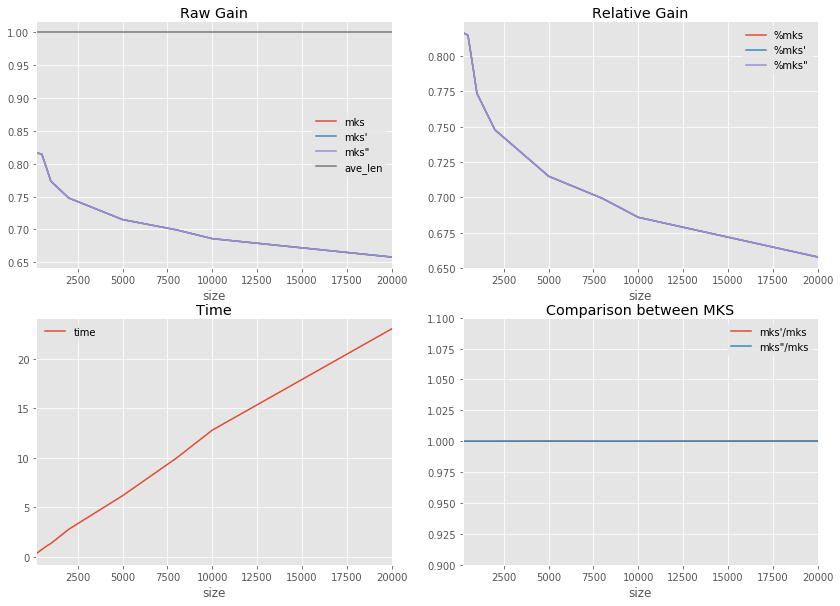

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
import time, random, pandas

def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    if len(c) != len(c.lower()):
        raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        o = ord(c.lower())
        a = 97
        d = (o - a) + size * 10
        return chr(97  + (d % size))

def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]

def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.clock()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 6.614798064180377s - nb=5000 gain (0.7150453742865438, 0.7150453742865438, 0.7150453742865438, 1.0)
time: 3.9943889967717894s - nb=4561 gain (0.4163175912734699, 0.4359863063216315, 0.4359863063216315, 1.0)
time: 5.13169970933626s - nb=4944 gain (0.5554662710676935, 0.5603082375241983, 0.5603082375241983, 1.0)
time: 5.2944637046647784s - nb=4977 gain (0.5959666560453883, 0.6003248054764654, 0.6003248054764654, 1.0)
time: 5.722569010721259s - nb=4988 gain (0.636508360379606, 0.6375867877244157, 0.6375867877244157, 1.0)
time: 5.985559610013681s - nb=4995 gain (0.6464832118287274, 0.6481055549851087, 0.6481055549851087, 1.0)
time: 5.81118189426202s - nb=4998 gain (0.66365829868064, 0.66365829868064, 0.66365829868064, 1.0)
time: 5.917329964707264s - nb=5000 gain (0.6699071982917995, 0.669927729643173, 0.669927729643173, 1.0)
time: 6.115613350946219s - nb=4999 gain (0.683475689881736, 0.6835578186596595, 0.6835578186596595, 1.0)
time: 6.10303018121904s - nb=4998 gain (0.6810874

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,6.904672,0.711473,0.711473,0.711473,1.0,0.711473,1.0,0.711473,1.0,0.711473,1.0
24,25,6.246688,0.712448,0.712448,0.712448,1.0,0.712448,1.0,0.712448,1.0,0.712448,1.0


In [ ]:
df = df.sort_values("size")

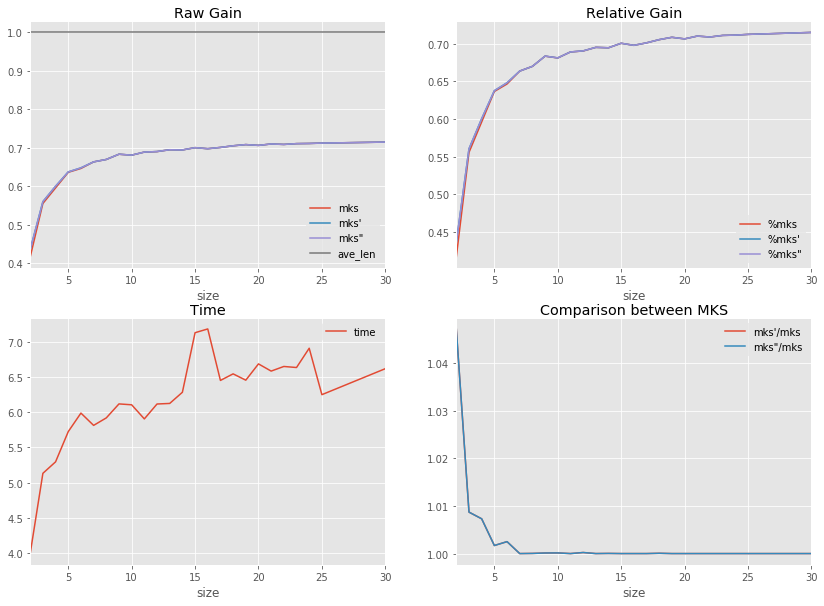

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
#ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [ ]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 52.04109447277054s - nb=50000 gain (0.6161289002557414, 0.6161657289002425, 0.6161657289002425, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,52.041094,0.616129,0.616166,0.616166,1.0,0.616129,1.0,0.616166,1.00006,0.616166,1.00006


In [ ]:
df2 = benchmark([50000, 100000, 200000]) # , 500000, 500000, 1000000, 2000000, None]) too long in python
df2.tail(n=2)

time 0
time: 53.184105991983586s - nb=50000 gain (0.6168893670316039, 0.6172221161826345, 0.6172221161826345, 1.0)
time: 100.61297633765406s - nb=100000 gain (0.582873144588145, 0.5832674092154916, 0.5832674092154916, 1.0)
time: 202.4190573976423s - nb=200000 gain (0.5486677983765011, 0.5501370913071402, 0.5501370913071402, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
1,100000,100.612976,0.582873,0.583267,0.583267,1.0,0.582873,1.0,0.583267,1.000676,0.583267,1.000676
2,200000,202.419057,0.548668,0.550137,0.550137,1.0,0.548668,1.0,0.550137,1.002678,0.550137,1.002678


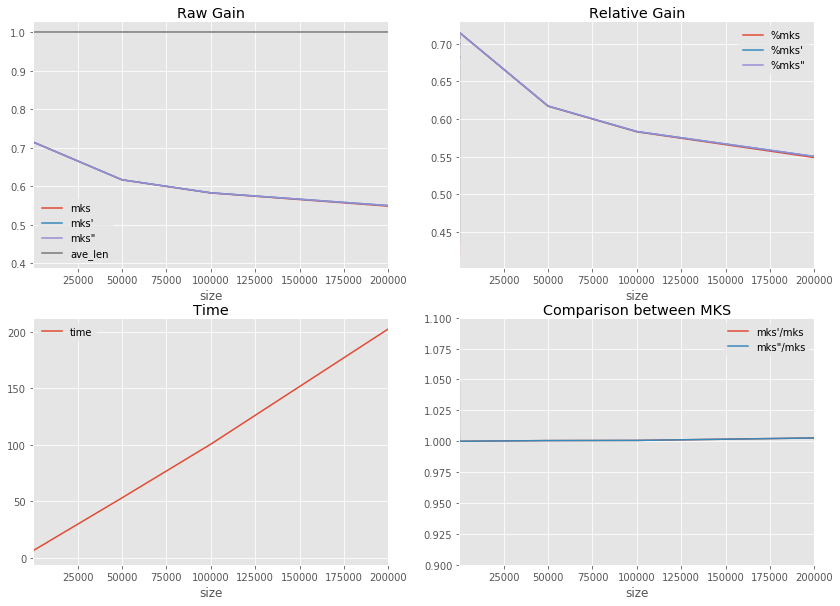

In [ ]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")